## Deface Detector

In [181]:
import cv2
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import random

In [182]:
def read_mri_image(filename):
    img = nib.load(filename)
    return img.get_data()

In [197]:
image_files = []

def load_files(path):
    if path.endswith('nii.gz'):
#         print(path)
        image_files.append(path)
    elif os.path.isdir(path):
        for file in os.listdir(path):
            load_files(os.path.join(path,file))
            


In [198]:
path = '../mri_data/small_set'
load_files(path)
print('Total Number of Images :', len(image_files))

Total Number of Images : 38


In [199]:
random.shuffle(image_files)
split = int(0.8*len(image_files))
train_files, val_files = image_files[:split], image_files[split:]
print('Number of train images :', len(train_files))
print('Number of test images :', len(val_files))

Number of train images : 30
Number of test images : 8


In [186]:
from keras import layers, models

def Conv_BN_RELU(x, filters=32, kernel=3, strides=1, padding='same'):
    x = layers.Conv2D(filters,kernel,strides=strides,padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def create_submodel():
    
    inp = layers.Input(shape=(None,None,1))
    
    conv1 = Conv_BN_RELU(inp, filters=8, kernel=5, strides=4, padding='same')
    
    conv2 = Conv_BN_RELU(conv1, filters=16, kernel=3, strides=1, padding='same')
    conv2 = Conv_BN_RELU(conv2, filters=16, kernel=2, strides=2, padding='same')

    conv3 = Conv_BN_RELU(conv2, filters=32, kernel=3, strides=1, padding='same')
    conv3 = Conv_BN_RELU(conv3, filters=32, kernel=2, strides=2, padding='same')

    conv4 = Conv_BN_RELU(conv2, filters=64, kernel=3, strides=1, padding='same')
    conv4 = Conv_BN_RELU(conv3, filters=64, kernel=2, strides=2, padding='same')
    
    out = layers.GlobalAveragePooling2D()(conv4)
    
    model = models.Model(inp,out)
    
    print(model.summary())
    
    return model
    
def create_model():
    
    inp1 = layers.Input(shape=(256,150,1), name='input_1')
    inp2 = layers.Input(shape=(256,150,1), name='input_2')
    inp3 = layers.Input(shape=(256,256,1), name='input_3')

    submodel = create_submodel()
    
    one = submodel(inp1)
    two = submodel(inp2)
    three = submodel(inp3)
    
    concat = layers.Concatenate()([one,two,three])
    out = layers.Dense(1,activation='sigmoid',name='output_node')(concat)

    return models.Model(inputs=[inp1,inp2,inp3],outputs=out)

In [187]:
model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 8)     208       
_________________________________________________________________
batch_normalization_8 (Batch (None, None, None, 8)     32        
_________________________________________________________________
activation_8 (Activation)    (None, None, None, 8)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
batch_normalization_9 (Batch (None, None, None, 16)    64        
_________________________________________________________________
activation_9 (Activation)    (None, None, None, 16)    0         
__________

In [188]:
import imgaug as ia
from imgaug import augmenters as iaa

def augment(images):
    
    sometimes = lambda aug : iaa.Sometimes(0.8,aug)
    
    # The commented augmentations sometimes destroyed the image. Need to discuss which ones are appropriate here
    
    seq = iaa.Sequential([
        sometimes(iaa.GaussianBlur(sigma=(0.0,3.0))),
#         sometimes(iaa.ContrastNormalization((0.9,1.1))),
#         sometimes(iaa.Multiply((0.95,1.05))),
#         iaa.Sharpen(alpha=(0, 0.5), lightness=(0.9, 1.1)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        
        iaa.OneOf([
            iaa.Affine(rotate=(90)),
            iaa.Affine(rotate=(-90))
        ])
    ])
    
    seq_det = seq.to_deterministic()
    aug_images = seq_det.augment_images(images)
    
    return aug_images

In [189]:
def batch_read(image_files):
    
    dim_0 = list()
    dim_1 = list()
    dim_2 = list()
    
    batch_y = list()

    for img_f in image_files:
        
        img = read_mri_image(img_f)
        m0 = np.mean(img,axis=0)
        m1 = np.mean(img,axis=1)
        m2 = np.mean(img,axis=2)
        dim_0.append(m0)
        dim_1.append(m1)
        dim_2.append(m2)
       
        if 'deface' in img_f:
            batch_y.append(1)
        else:
            batch_y.append(0)
        
    dim_0 = augment(dim_0)
    dim_1 = augment(dim_1)
    dim_2 = augment(dim_2)
            
    dim_0 = np.expand_dims(dim_0,axis=3)
    dim_1 = np.expand_dims(dim_1,axis=3)
    dim_2 = np.expand_dims(dim_2,axis=3)
            
    return ([dim_0, dim_1, dim_2], np.array(batch_y))

In [190]:
def generator(image_files, batch_size):
    
    while True:
        
        random.shuffle(image_files)
        
        for i in range(0, len(image_files), batch_size):
            batch_image_files = image_files[i:i+batch_size]
            
            batch_x, batch_y = batch_read(batch_image_files)
            
            yield (batch_x,batch_y)

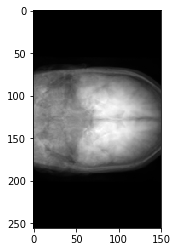

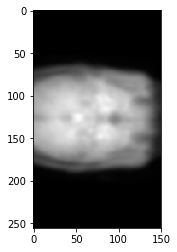

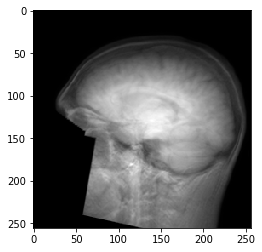

In [191]:
# To check generator

g = generator(image_files, 2)
batch_x, batch_y = next(g)

plt.imshow(np.squeeze(batch_x[0][0]), 'gray')
plt.show()

plt.imshow(np.squeeze(batch_x[1][0]), 'gray')
plt.show()

plt.imshow(np.squeeze(batch_x[2][0]), 'gray')
plt.show()

In [193]:
os.makedirs('models',exist_ok=True)

In [194]:
from keras.callbacks import ModelCheckpoint

batch_size = 4

train_gen = generator(train_files, batch_size)
val_gen = generator(val_files, batch_size)

checkpoint = ModelCheckpoint(filepath='models/model_best.h5', save_best_only=True, monitor='val_loss',
                             save_weights_only=False)

model.fit_generator(train_gen, steps_per_epoch=len(train_files)//batch_size,
                    validation_data=val_gen, validation_steps=len(val_files)//batch_size,
                    epochs=10, callbacks=[checkpoint])

Epoch 1/10
7/7 [==============================] - 8s 1s/step - loss: 0.6656 - acc: 0.6071 - val_loss: 0.6443 - val_acc: 0.6250
Epoch 2/10
7/7 [==============================] - 7s 982ms/step - loss: 0.6326 - acc: 0.5721 - val_loss: 0.5441 - val_acc: 0.6250
Epoch 3/10
7/7 [==============================] - 6s 887ms/step - loss: 0.6244 - acc: 0.7163 - val_loss: 0.5585 - val_acc: 0.7500
Epoch 4/10
7/7 [==============================] - 6s 880ms/step - loss: 0.6515 - acc: 0.6442 - val_loss: 0.5300 - val_acc: 0.7500
Epoch 5/10
7/7 [==============================] - 6s 903ms/step - loss: 0.6600 - acc: 0.5361 - val_loss: 0.5998 - val_acc: 0.6250
Epoch 6/10
7/7 [==============================] - 6s 873ms/step - loss: 0.5972 - acc: 0.7115 - val_loss: 0.6444 - val_acc: 0.5000
Epoch 7/10
7/7 [==============================] - 6s 915ms/step - loss: 0.5394 - acc: 0.7837 - val_loss: 0.5374 - val_acc: 0.7500
Epoch 8/10
7/7 [==============================] - 6s 927ms/step - loss: 0.5856 - acc: 0.7837 

In [200]:
model.save('models/final_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('models/best_model.h5')